# Transformers for Peak Detection

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import math
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, f1_score
plt.style.use("seaborn-v0_8")
from sklearn.preprocessing import MinMaxScaler

## Data Preprocessing

In [2]:

csv_path = "/content/DMC2_S_CP2_52.csv"
target = "CURRENT|6"
output_path = "/content/X_test_with_peaks.csv"

df = pd.read_csv(csv_path)
y = df[[target]].values
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)
df['y_scaled'] = y_scaled

#print(df.head())
#print(y)

print("\nDONE - Load and Normalize")

#print(df['y_scaled'].value_counts())


DONE - Load and Normalize


## Config

In [3]:
## D_Model [16, 32, 64]
# Window_size [30, 60, 120]

In [4]:
# 🧠 hyperparameters & Config
FEATS = 1                  # Input feature dimension
DIM_FEEDFORWARD = 64       # Hidden units in FFN
NUM_HEADS = 1              # Attention heads (must divide D_MODEL)
NUM_ENCODER_LAYERS = 1     # Transformer encoder layers
NUM_DECODER_LAYERS = 1     # Transformer decoder layers
DROPOUT = 0.1              # Dropout rate

D_MODEL = 16           # Model dimension (used for projecting input)
window_size = 60

batch_size = 128
num_epochs = 50
lr = 0.001

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # create the folder if it doesn't exist


print("\nDONE - Config")



DONE - Config


### Sliding Windows

In [5]:
def create_windows(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size)])


X_all = create_windows(y_scaled, window_size)
y_all = X_all.copy()  # since it's reconstruction

print("\nDONE - Create Sliding Window")

# Flatten each window for saving and inspection
X_all_2d = X_all.reshape(X_all.shape[0], -1)
X_all_df = pd.DataFrame(X_all_2d)


DONE - Create Sliding Window


### Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test = train_test_split(X_all_df, test_size=0.4, random_state=42)
X_test.reset_index(drop=True, inplace=True)

# Convert to torch tensor for model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(-1)  # [B, T, 1]
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(-1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


print("\nDONE - Train-Test Split")


X_train shape: (25173, 60)
X_test shape: (16783, 60)

DONE - Train-Test Split


## Model Building

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create sinusoidal positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term[:(d_model // 2 + 1)])  # handles both even/odd d_model

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Add positional encoding to input tensor
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class PeakAD_Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        # Project input features into higher dimension
        self.input_proj = nn.Linear(FEATS, D_MODEL)

        # Add positional encoding for combined input + error sequence
        self.pos_encoder = PositionalEncoding(D_MODEL * 2, DROPOUT, window_size)

        # Define encoder block
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=D_MODEL * 2,
            nhead=NUM_HEADS,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_ENCODER_LAYERS)

        # Define decoder block
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=D_MODEL * 2,
            nhead=NUM_HEADS,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=NUM_DECODER_LAYERS)

        # Output layer to project back to original feature dimension
        self.output_layer = nn.Sequential(
            nn.Linear(D_MODEL * 2, FEATS),
            nn.Sigmoid()
        )

    def encode(self, src, err, tgt):
        # Project source and error
        src_enc = self.input_proj(src)
        err_enc = self.input_proj(err)

        # Concatenate source and error for self-conditioning
        combined = torch.cat((src_enc, err_enc), dim=2)
        combined = combined * math.sqrt(D_MODEL)

        # Add positional encoding
        encoded = self.pos_encoder(combined)

        # Pass through transformer encoder
        memory = self.encoder(encoded)

        # Project and duplicate target for decoding
        tgt_proj = self.input_proj(tgt)
        tgt_combined = torch.cat((tgt_proj, tgt_proj), dim=2)

        return tgt_combined, memory

    def forward(self, src, tgt):
        # Phase 1: Without anomaly signal
        err = torch.zeros_like(src)
        tgt1, mem1 = self.encode(src, err, tgt)
        x1 = self.output_layer(self.decoder(tgt1, mem1))

        # Phase 2: With self-conditioning using reconstruction error
        err = (x1 - src) ** 2
        tgt2, mem2 = self.encode(src, err, tgt)
        x2 = self.output_layer(self.decoder(tgt2, mem2))

        return x2  # Final reconstructed sequence

## Model Training

In [8]:

model = PeakAD_Transformer()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

# previous checkpoint to resume from
start_epoch = 1  # default
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_")]
if checkpoint_files:
    latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split("_")[-1].split(".")[0]))[-1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔁 Resuming training from epoch {start_epoch} (loaded {latest_checkpoint})")

# Training loop
model.train()
for epoch in range(start_epoch, num_epochs + 1):
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        x2 = model(xb, xb)
        loss = criterion(x2, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss:.4f}")

    # Save checkpoint every 50 epochs
    if epoch % 10 == 0 or epoch == num_epochs:
        ckpt_path = f"checkpoint_epoch_{epoch}_Ws{window_size}_Dim{D_MODEL}.pt"
        checkpoint_path = os.path.join(checkpoint_dir, ckpt_path)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved at: {checkpoint_path}")

print("DONE: Training complete")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1/50, Loss: 0.2252
Epoch 2/50, Loss: 0.0352
Epoch 3/50, Loss: 0.0117
Epoch 4/50, Loss: 0.0077
Epoch 5/50, Loss: 0.0073
Epoch 6/50, Loss: 0.0049
Epoch 7/50, Loss: 0.0045
Epoch 8/50, Loss: 0.0046
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0033
Checkpoint saved at: ./checkpoints/checkpoint_epoch_10_Ws60_Dim16.pt
Epoch 11/50, Loss: 0.0034
Epoch 12/50, Loss: 0.0030
Epoch 13/50, Loss: 0.0028
Epoch 14/50, Loss: 0.0023
Epoch 15/50, Loss: 0.0023
Epoch 16/50, Loss: 0.0020
Epoch 17/50, Loss: 0.0019
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0015
Epoch 20/50, Loss: 0.0042
Checkpoint saved at: ./checkpoints/checkpoint_epoch_20_Ws60_Dim16.pt
Epoch 21/50, Loss: 0.0012
Epoch 22/50, Loss: 0.0011
Epoch 23/50, Loss: 0.0035
Epoch 24/50, Loss: 0.0019
Epoch 25/50, Loss: 0.0010
Epoch 26/50, Loss: 0.0009
Epoch 27/50, Loss: 0.0009
Epoch 28/50, Loss: 0.0010
Epoch 29/50, Loss: 0.0009
Epoch 30/50, Loss: 0.0009
Checkpoint saved at: ./checkpoints/checkpoint_epoch_30_Ws60_Dim16.pt
Epoch 31/50, Loss: 0.0

## Plot RE

In [9]:
def plot_reconstruction_errors_per_timestep(model, scaler_y, X_input, threshold_percentile=98):
    model.eval()
    with torch.no_grad():
        x2 = model(X_input, X_input)  # [B, window, 1]

        # Use only the last timestep of each reconstructed sequence
        recon = x2[:, -1, 0].cpu().numpy()  # shape: [B]
        true = X_input[:, -1, 0].cpu().numpy()  # shape: [B]

        # Inverse transform back to original scale
        recon_orig = scaler_y.inverse_transform(recon.reshape(-1, 1)).flatten()
        true_orig = scaler_y.inverse_transform(true.reshape(-1, 1)).flatten()

        # Compute per-timestep error
        errors = np.abs(true_orig - recon_orig)

        # Threshold for peak detection
        threshold = np.percentile(errors, threshold_percentile)
        peaks = [i for i, e in enumerate(errors) if e > threshold]

        # Plot
        plt.figure(figsize=(14, 6))
        plt.plot(errors, label="Reconstruction Error (per timestamp)", alpha=0.8)
        plt.axhline(threshold, color="red", linestyle="--", label=f"{threshold_percentile}th percentile")
        plt.scatter(peaks, [errors[i] for i in peaks], color='red', s=10, label="Detected Peaks")

        #clear timestamp labels
        plt.xticks(ticks=np.arange(0, len(errors), 300), rotation=90)  # Show all timestamps (rotate for clarity)

        plt.title("Tran-PD")
        plt.xlabel("Timestamp Index")
        plt.ylabel("Reconstruction Error")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

         # Save plot directly
        plot_filename = f"reconsn_errors_Ws{window_size}_Dim{D_MODEL}.png"
        plt.savefig(plot_filename)
        print(f"📸 Plot saved as: {plot_filename}")
        plt.show()

        return errors, peaks, true_orig, recon_orig, threshold

📸 Plot saved as: reconsn_errors_Ws60_Dim16


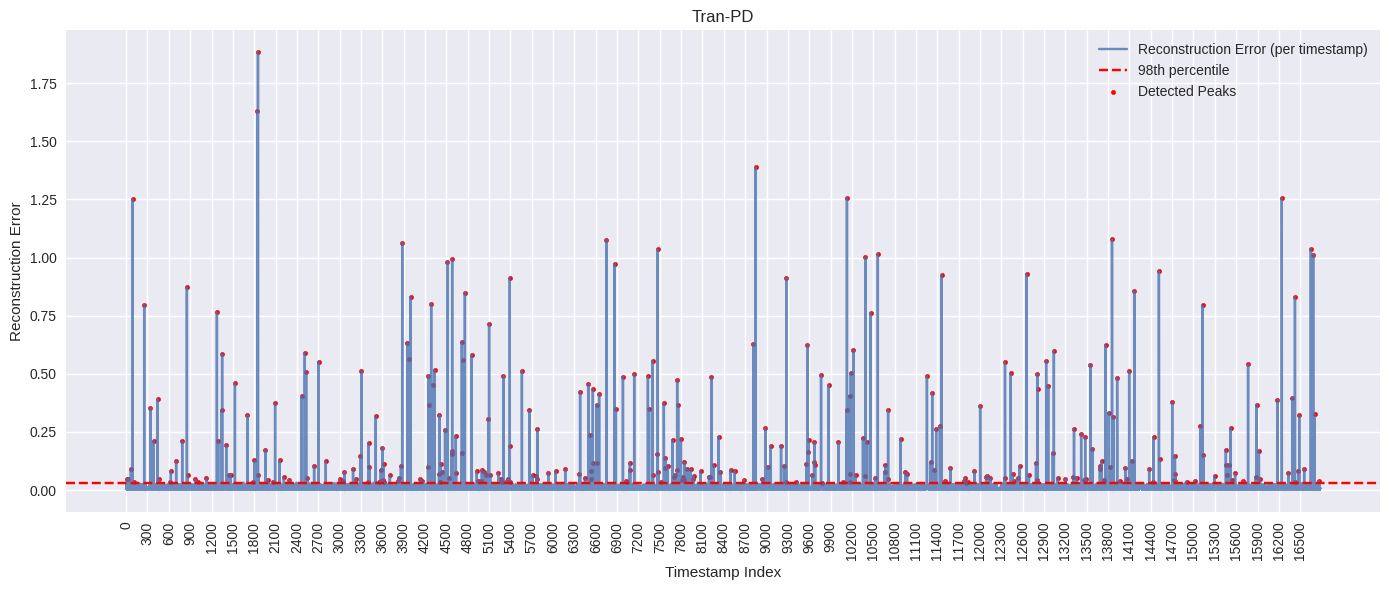

0.03241028

 DONE - 336 Peaks Detected in WINDOW_SIZE - 60, D-MODEL - 16 


In [10]:
errors, peaks, true_orig, recon_orig, threshold = plot_reconstruction_errors_per_timestep(model, scaler_y, X_test_tensor)

### num_of_peaks
num_of_peaks = len(peaks)
print(threshold)

print(f"\n DONE - {len(peaks)} Peaks Detected in WINDOW_SIZE - {window_size}, D-MODEL - {D_MODEL} ")

In [11]:
summary_path = "/content/peak_summary.txt"

with open(summary_path, "a") as f:
    f.write(f"Number of Peaks Detected: {len(peaks)}\n")
    f.write(f"Window Size: {window_size}\n")
    f.write(f"D_MODEL: {D_MODEL}\n")
    f.write(f"Threshold: {threshold}\n")
    f.write(f"Mean RE: {np.mean(errors)} | Max RE: {np.max(errors)} | Min RE: {np.min(errors)}")
    f.write("\n-" * 40 + "\n")


print(f"📄 Summary saved to: {summary_path}")

📄 Summary saved to: /content/peak_summary.txt


### Save Errors and Peaks

### Save Peaks Details into Dataset

In [12]:
start_index = window_size
timestamp_indices = np.arange(start_index, start_index + len(true_orig))

# Create the Peaks dataset
Peaks = pd.DataFrame({
    'Timestamp': timestamp_indices,
    'True_Value': true_orig,
    'Reconstructed_Value': recon_orig,
    'Reconstruction_Error': errors,
    'Peak': (errors > threshold).astype(int),
})

Peaks.to_csv(f"/content/Peaks_Ws{window_size}_Dim{D_MODEL}.csv", index=False)
print("Saved Peaks dataset to: /content/Peaks.csv")

Saved Peaks dataset to: /content/Peaks.csv


## Statistical TEST DATASET

In [ ]:
#### Save error and peaks code

X_test['True_Value'] = true_orig
X_test['Reconstructed_Value'] = recon_orig
X_test['Reconstruction_Error'] = errors
X_test['Peak'] = (errors > threshold).astype(int)

# Save
output_path = "/content/X_test_with_peaks.csv"
X_test.to_csv(output_path, index=False)
print(f" Saved test set with peaks to: {output_path}")

In [ ]:
# Initialize global lists to collect results
win_size_list = []
d_model_list = []
num_peaks_list = []

In [ ]:
## FInal TEST DATASET

# Statistical_test_dataset = pd.DataFrame({
#     'Win_size': win_size_list,
#     'D_model': d_model_list,
#     'Num_of_Peaks': num_peaks_list,
# })

Statistical_test_dataset.to_csv("/content/Statistical_test_dataset.csv", index=False)
print("Saved TEST dataset to: /content/Statistical_test_dataset.csv")

NameError: name 'win_size_list' is not defined

## ANOVA and Tukey's Test

In [ ]:
import os
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def analyze_transformer_dataset(df, filename, output_folder="./"):
    # backticks to handle hyphen in 'D-model'
    formula = 'Num_of_Peaks ~ C(Win_size) + C(D_model) + C(Win_size):C(D_model)'

    # Fit the ANOVA model
    model = ols(formula, data=df).fit()

    # Run ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\n📊 ANOVA Results:\n", anova_table)

    # Save ANOVA table
    anova_table["Dataset"] = filename
    anova_csv = os.path.join(output_folder, f"anova_{filename}.csv")
    anova_table.to_csv(anova_csv, index=True)
    print(f"\n📁 Saved ANOVA results to: {anova_csv}")

    # Find significant factors (p < 0.05)
    significant_factors = anova_table[anova_table["PR(>F)"] < 0.05].index.tolist()
    print("\nSignificant Factors:", significant_factors)

    # Run Tukey’s HSD for each main factor
    tukey_results = []
    for factor in significant_factors:
        if "C(" in factor:
            factor_name = factor.split('(')[1].split(')')[0].strip('`')  # clean backticks if any
            tukey_test = pairwise_tukeyhsd(df['Num_of_Peaks'], df[factor_name])
            tukeydf = pd.DataFrame(data=tukey_test._results_table.data[1:], columns=tukey_test._results_table.data[0])
            tukeydf["Dataset"] = filename
            tukeydf["Factor"] = factor_name
            tukey_results.append(tukeydf)
            print(f"\nTukey’s HSD for {factor_name}:\n", tukey_test)

    # Save Tukey results
    if tukey_results:
        tukey_results_df = pd.concat(tukey_results, ignore_index=True)
        tukey_csv = os.path.join(output_folder, f"tukey_{filename}.csv")
        tukey_results_df.to_csv(tukey_csv, index=False)
        print(f"\nSaved Tukey HSD results to: {tukey_csv}")

In [ ]:
df = pd.read_csv("/content/Statistical_test_dataset.csv")

# Check for NaNs or infinite values
print("NaN values:\n", df.isna().sum())
print("\nInfinite values:\n", (df == float('inf')).sum())

print(df.groupby(['Win_size', 'D_model']).size())

NaN values:
 Win_size        0
D_model         0
Num_of_Peaks    0
dtype: int64

Infinite values:
 Win_size        0
D_model         0
Num_of_Peaks    0
dtype: int64
Win_size  D_model
30        8          1
60        16         1
dtype: int64


In [ ]:
df = pd.read_csv("/content/Statistical_test_dataset.csv")
analyze_transformer_dataset(df, filename="transformer_test", output_folder="/content")

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: array must not contain infs or NaNs

### Interactive Plot

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Load  dataset
peaks_df = pd.read_csv("/content/Peaks.csv")  # Adjust path if needed

# Create interactive line plot
fig = go.Figure()

# Line: Reconstruction Error
fig.add_trace(go.Scatter(
    x=peaks_df["Timestamp"],
    y=peaks_df["Reconstruction_Error"],
    mode='lines',
    name='Reconstruction Error',
    line=dict(color='blue')
))

# Points: Detected Peaks
fig.add_trace(go.Scatter(
    x=peaks_df.loc[peaks_df["Peak"] == 1, "Timestamp"],
    y=peaks_df.loc[peaks_df["Peak"] == 1, "Reconstruction_Error"],
    mode='markers',
    name='Detected Peaks',
    marker=dict(color='red', size=8, symbol='circle'),
    hovertemplate='Timestamp: %{x}<br>Error: %{y:.4f}'
))

# Layout adjustments
fig.update_layout(
    title="Interactive Reconstruction Error",
    xaxis_title="Timestamp",
    yaxis_title="Reconstruction Error",
    legend=dict(x=0.01, y=0.99),
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

### Error Details - Distribution

In [ ]:

peaks_df = pd.read_csv("/content/Peaks_w30_d8.csv")


errors = peaks_df['Reconstruction_Error']


min_error = errors.min()
max_error = errors.max()
mean_error = errors.mean()
threshold_98 = np.percentile(errors, 98)

# Print results
print(f"Min Error: {min_error}")
print(f"Max Error: {max_error}")
print(f"Mean Error: {mean_error}")
print(f"98th Percentile Threshold: {threshold_98}")

Min Error: 0.00015282631
Max Error: 1.5031357
Mean Error: 0.06672721650209348
98th Percentile Threshold: 0.0961675575199996


## To shorten Dataset Length

In [ ]:

df = pd.read_csv("/content/DMC2_S_CP2_52.csv")

# Take 20% of the data
df_20 = df.sample(frac=0.2, random_state=42).reset_index(drop=True)

# Save to new file
df_20.to_csv("/content/dataset_20.csv", index=False)

print("✅ New file 'dataset_20.csv' created with 20% of the data.")

✅ New file 'dataset_20.csv' created with 20% of the data.


### Datasset Info

In [ ]:
df_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8403 entries, 0 to 8402
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LOAD|1        8403 non-null   float64
 1   LOAD|2        8403 non-null   float64
 2   LOAD|3        8403 non-null   float64
 3   LOAD|6        8403 non-null   float64
 4   ENC_POS|1     8403 non-null   float64
 5   ENC_POS|2     8403 non-null   float64
 6   ENC_POS|3     8403 non-null   float64
 7   ENC_POS|6     8403 non-null   float64
 8   CTRL_DIFF2|1  8403 non-null   float64
 9   CTRL_DIFF2|2  8403 non-null   float64
 10  CTRL_DIFF2|3  8403 non-null   float64
 11  CTRL_DIFF2|6  8403 non-null   float64
 12  TORQUE|1      8403 non-null   float64
 13  TORQUE|2      8403 non-null   float64
 14  TORQUE|3      8403 non-null   float64
 15  TORQUE|6      8403 non-null   float64
 16  DES_POS|1     8403 non-null   float64
 17  DES_POS|2     8403 non-null   float64
 18  DES_POS|3     8403 non-null 

In [ ]:
df.shape

(42016, 56)

## IMP Code snippets

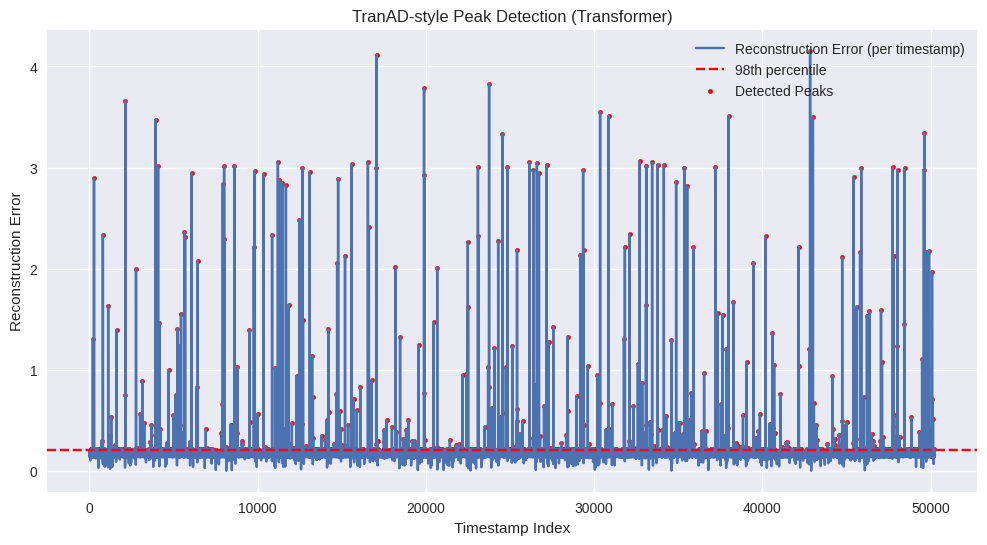


✅ DONE - 1003 Peaks Detected


In [ ]:

def plot_reconstruction_errors_per_timestep(model, scaler_y, X_input, threshold_percentile=98):
    model.eval()
    with torch.no_grad():
        x2 = model(X_input, X_input)
        recon = x2.cpu().numpy().reshape(-1, 1)
        true = X_input.cpu().numpy().reshape(-1, 1)
        recon_orig = scaler_y.inverse_transform(recon).flatten()
        true_orig = scaler_y.inverse_transform(true).flatten()
        errors = np.abs(true_orig - recon_orig)

        threshold = np.percentile(errors, threshold_percentile)
        peaks = [i for i, e in enumerate(errors) if e > threshold]

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(errors, label="Reconstruction Error (per timestamp)")
        plt.axhline(threshold, color="red", linestyle="--", label=f"{threshold_percentile}th percentile")
        plt.scatter(peaks, [errors[i] for i in peaks], color='red', s=10, label="Detected Peaks")
        plt.title("TranAD-style Peak Detection (Transformer)")
        plt.xlabel("Timestamp Index")
        plt.ylabel("Reconstruction Error")
        plt.legend()
        plt.grid(True)
        plt.show()

        return errors, peaks

# 9. Run and Plot
errors, peaks = plot_reconstruction_errors_per_timestep(model, scaler_y, X_test_tensor)
print(f"\n✅ DONE - {len(peaks)} Peaks Detected")




## Dataset
not_non_features = [
       'LOAD|1', 'LOAD|2', 'LOAD|3', 'LOAD|6',
       'ENC_POS|1', 'ENC_POS|2', 'ENC_POS|3','ENC_POS|6',
       'CTRL_DIFF2|1', 'CTRL_DIFF2|2', 'CTRL_DIFF2|3', 'CTRL_DIFF2|6',
       'TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6',
       'DES_POS|1', 'DES_POS|2', 'DES_POS|3', 'DES_POS|6',

       #'CURRENT|1', 'CURRENT|2', 'CURRENT|3',


       'CTRL_DIFF|1', 'CTRL_DIFF|2', 'CTRL_DIFF|3' ,'CTRL_DIFF|6',
       'CTRL_POS|1', 'CTRL_POS|2', 'CTRL_POS|3', 'CTRL_POS|6',
       'VEL_FFW|1', 'VEL_FFW|2','VEL_FFW|3', 'VEL_FFW|6',
       #'POWER|1','POWER|2', 'POWER|3', 'POWER|6',
       'CONT_DEV|1','CONT_DEV|2', 'CONT_DEV|3', 'CONT_DEV|6',
       #'A_DBD|0',
       'CMD_SPEED|1', 'CMD_SPEED|2', 'CMD_SPEED|3', 'CMD_SPEED|6',
       'TORQUE_FFW|1', 'TORQUE_FFW|2', 'TORQUE_FFW|3', 'TORQUE_FFW|6',
       'ENC1_POS|1', 'ENC1_POS|2', 'ENC1_POS|3','ENC1_POS|6',
       'ENC2_POS|1', 'ENC2_POS|2', 'ENC2_POS|3', 'ENC2_POS|6']
target = 'CURRENT|6'

In [ ]:
dftest = pd.read_csv("/content/DMC2_S_CP2_52.csv")

dftest.shape

(42016, 56)